In [1]:
import cv2
import faceBlendCommon as fbc
from matplotlib import pyplot as plt
import dlib
import numpy as np

In [2]:
# Load imports
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

In [3]:
# Read Images
img1 = cv2.imread("ted_cruz.jpg")
img2 = cv2.imread("donald_trump.jpg")
img1Warped = np.copy(img2)

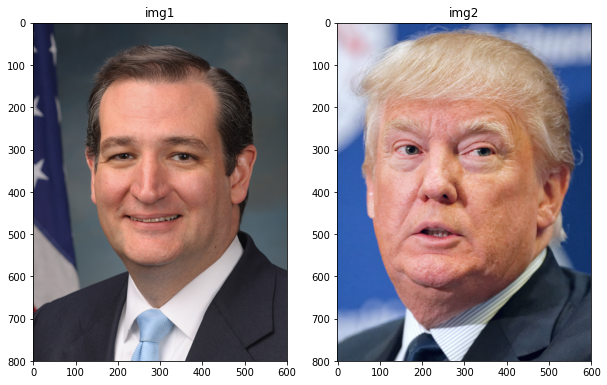

In [4]:
# Display images
plt.figure(figsize=(10,10))
plt.subplot(121);plt.title("img1");plt.imshow(img1[:,:,::-1])
plt.subplot(122);plt.title("img2");plt.imshow(img2[:,:,::-1])
plt.show()

In [5]:
# Initialize Face Detector and Landmark Detector
faceDetector = dlib.get_frontal_face_detector()
landmarkDetector = dlib.shape_predictor("../shape_predictor_68_face_landmarks.dat")

In [6]:
# Detect Faces
src = faceDetector(img1)
dst = faceDetector(img2)

In [7]:
# Get LandMark Points
src_pts = landmarkDetector(img1,src[0])
dst_pts = landmarkDetector(img2,dst[0])

In [18]:
# Find Convex Hull for both images. Note here the convex hull will be based on target image/ destination image. 
#This is the image on which we need to swap the face with
hull1 = []
hull2 = []
src_num_parts = src_pts.num_parts
dst_num_parts = dst_pts.num_parts
pts1 = []
pts2 = []
for i in range(0, src_num_parts):
    pts1.append((src_pts.part(i).x,src_pts.part(i).y))

for j in range(0, dst_num_parts):
    pts2.append((dst_pts.part(j).x,dst_pts.part(j).y))

hullIndex_1 = cv2.convexHull(np.array(pts2), returnPoints=False)

for i in range(0, len(hullIndex_1)):
    hull1.append(pts1[hullIndex_1[i][0]])
    hull2.append(pts2[hullIndex_1[i][0]])

In [19]:
# Calculate delaunay triangulation
sizeImg2 = img2.shape
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = fbc.calculateDelaunayTriangles(rect, hull2)

if(len(dt) == 0):
    print("No delaunay triangles")

In [20]:
print(hull1)
print(dt)

[(463, 328), (458, 412), (451, 454), (433, 493), (402, 526), (362, 552), (317, 571), (271, 575), (230, 565), (200, 539), (175, 509), (159, 474), (150, 437), (147, 401), (147, 366), (149, 328), (159, 301), (170, 280), (193, 270), (365, 269), (395, 279)]
[(2, 19, 1), (19, 2, 3), (1, 19, 20), (0, 1, 20), (4, 19, 3), (19, 4, 5), (12, 19, 5), (19, 12, 13), (6, 10, 11), (10, 6, 9), (7, 9, 6), (9, 7, 8), (5, 6, 11), (5, 11, 12), (14, 19, 13), (19, 14, 18), (18, 14, 15), (18, 15, 16), (18, 16, 17)]


In [21]:
len(hull1)

21

In [30]:
len(hull2)

21

In [22]:
# Warp Triangle
for i in range(0, len(dt)):
    t1 = []
    t2 = []
    
    for j in range(0, 3):
        t1.append(hull1[dt[i][j]])
        t2.append(hull2[dt[i][j]])
    fbc.warpTriangle(img1, img1Warped, t1, t2)

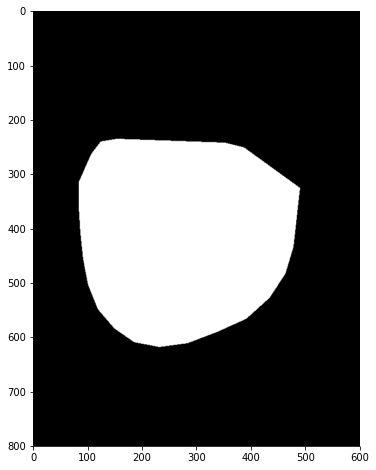

In [23]:
#Calculate mask
mask = np.zeros(img2.shape, dtype=img2.dtype)
cv2.fillConvexPoly(mask, np.int32(hull2), (255,255,255))
plt.imshow(mask)

In [24]:
#Find the center
r = cv2.boundingRect(np.float32([hull2]))
center = (r[0] + int(r[2]/2), r[1] + int(r[3]/2))

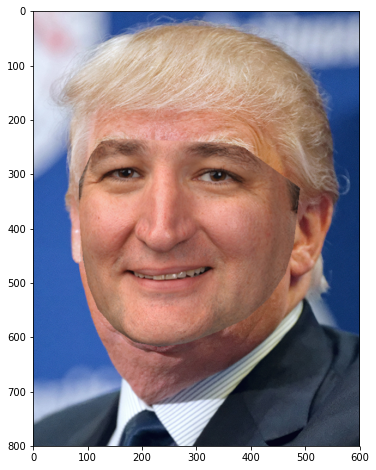

In [29]:
plt.imshow(img1Warped[:,:,::-1])

In [26]:
center

(287, 426)

In [27]:
#Seamless Clonning
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)

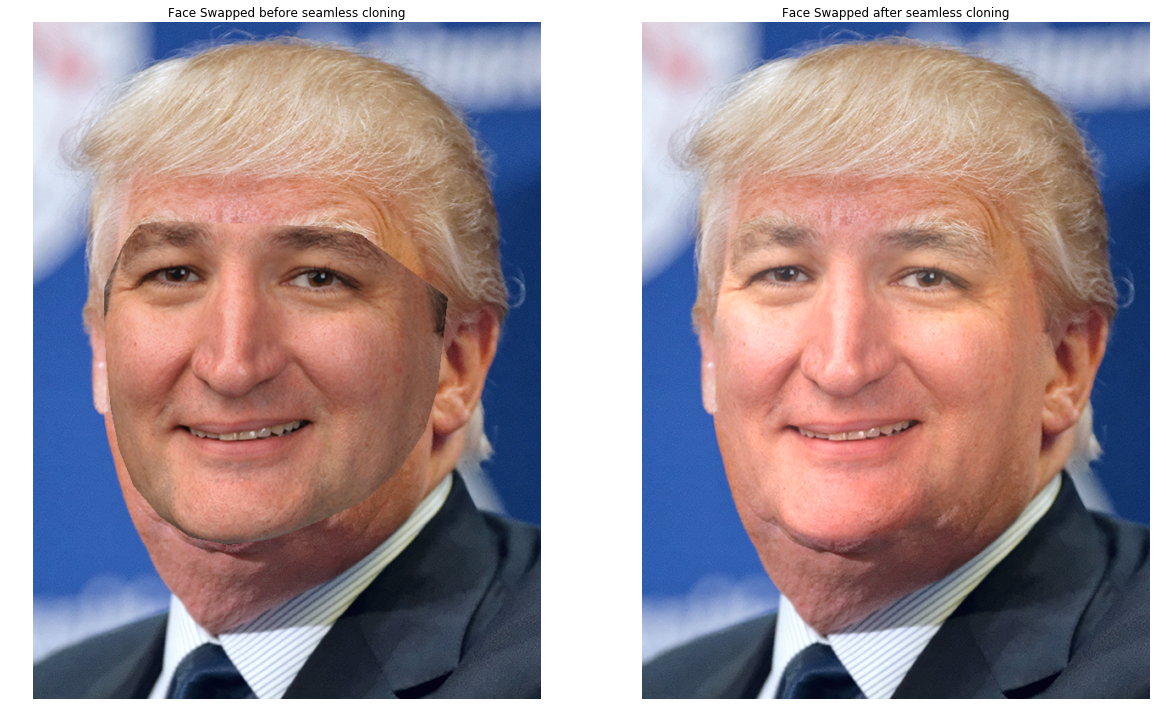

In [28]:
plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(np.uint8(img1Warped)[:,:,::-1])
plt.title("Face Swapped before seamless cloning")
plt.axis('off')

plt.subplot(122)
plt.imshow(output[:,:,::-1])
plt.title("Face Swapped after seamless cloning")
plt.axis('off')

plt.show()